# Static Bayesian Optimization: 
- Sina Dabiri 


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [3]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)
        # sum of post stimulation gamma         
        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        
       
        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
        
        # Min and Max of State
        
        # Number of trials
        
        
        return U1_X0, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        ucb = simY+(np.sqrt(nu*tau_t))*simMse
        
        return ucb
    
    # The next step training and bayes_opt_update_state() function
    def bayes_opt_update_state(self, U1, X1, ker_BaO):
         # create simple GP model
        trained_model_BaO = GPy.models.GPRegression(U1,X1,ker_BaO)
        trained_model_BaO.optimize(messages=True,max_f_eval = 1000);
        
        return trained_model_BaO
    
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [4]:
model = state_dr_gp()

In [5]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [6]:
print('Sum preStim gamma are: \n', X0_psd, '\n','freq and amplitude used are: \n', U1[0:4])

Sum preStim gamma are: 
      sum_preStim_gamma
0             3.266571
1             2.425945
2             3.117866
3             2.868627
4             3.521665
..                 ...
379           1.268502
380           1.239859
381           1.880050
382           1.199899
383           1.343332

[384 rows x 1 columns] 
 freq and amplitude used are: 
    Stim_1  Stim_2
0      17      30
1      42      40
2      35      30
3      23      50


In [7]:
U1.loc[0:10, 'Stim_1']

0     17
1     42
2     35
3     23
4     42
5     35
6     11
7      7
8     17
9     11
10    17
Name: Stim_1, dtype: int64

In [8]:
print(np.shape(U1), np.shape(X0_psd))

(384, 2) (384, 1)


In [9]:
n_burn_in = 20
n_samples= 150
n_acquisition = 50

## 1.2 First BaO Model is trained on all of the dataset

In [10]:
ker_BaO = GPy.kern.Matern52(input_dim=2, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [11]:
slice_dim = 1
ylabel='Predicted Gamma'

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x26a13453790>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x26a13453bb0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s17  0001   3.584623e+03   5.735294e+05 
    01s25  0010   1.144314e+03   3.389054e+01 
    03s39  0032   1.115247e+03   8.381424e-08 
    03s57  0034   1.115247e+03   6.434336e-10 
Runtime:     03s57
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x26a120661f0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x26a12045ee0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x26a1456c7f0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x26a14577d90>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x26a14577dc0>]}

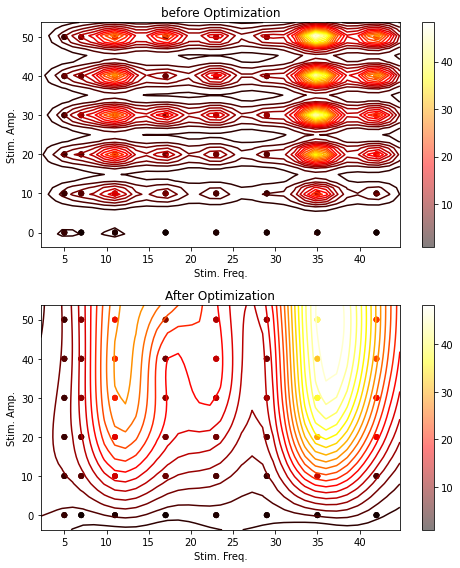

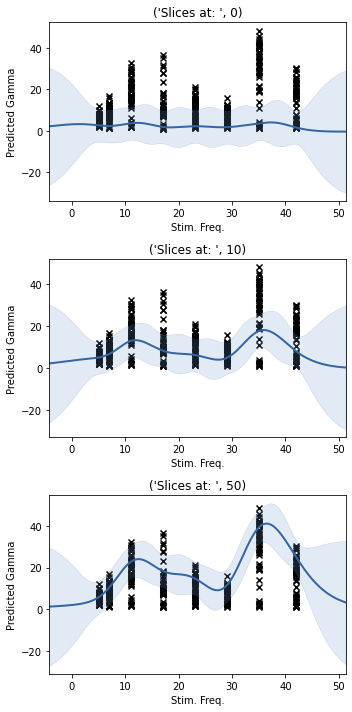

In [12]:
x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1, X0_psd, X1, ker_BaO, slice_dim, ylabel)

## 1.3: Train the second model on just the burn-in points, and then use the Acquisition function to pick the next freq/amp/PreStimGamma 

- Then get the suggested freq/amp/preStimGamma from the first model 
- Plot freq/amp/PostStimGamma after 50 interations of acquisition function

In [13]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1.loc[0:n_burn_in-1,:]
X0_psd_init = X0_psd.loc[0:n_burn_in-1]
X1_init = X1[0:n_burn_in,:]
print('Sum preStim gamma are: \n', X0_psd_init, '\n','freq and amplitude used are: \n', U1_init, np.shape(U1_init))
print('sum postStim gamma are: \n', X1_init, np.shape(X1_init))

Sum preStim gamma are: 
     sum_preStim_gamma
0            3.266571
1            2.425945
2            3.117866
3            2.868627
4            3.521665
5            1.384478
6            1.420178
7            1.533292
8            2.019014
9            2.231953
10           2.347957
11           2.131811
12           1.934441
13           2.512154
14           4.690816
15           2.645199
16           6.401632
17           1.984354
18           3.580944
19           2.032816 
 freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [

In [14]:
# input_data
U1_X0_init = U1_init.join(X0_psd_init)

In [15]:
ker_BaO_AF = GPy.kern.Matern52(input_dim=2, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

#### 1.3.1: initial training

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x26a14dff4c0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x26a14dff3a0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0005   3.497163e+02   8.940937e+02 
    00s17  0011   8.975792e+01   2.859550e-01 
    00s18  0012   8.539591e+01   9.174011e-02 
    00s65  0053   6.946105e+01   2.090506e-10 
Runtime:     00s65
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x26a169df760>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x26a169c62b0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x26a16dd4b80>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x26a16de4100>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x26a16de4130>]}

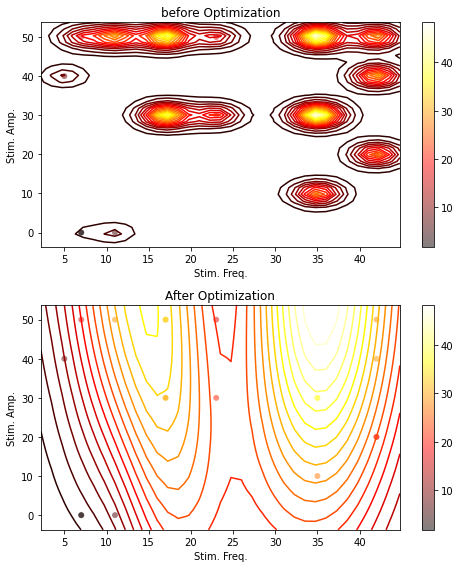

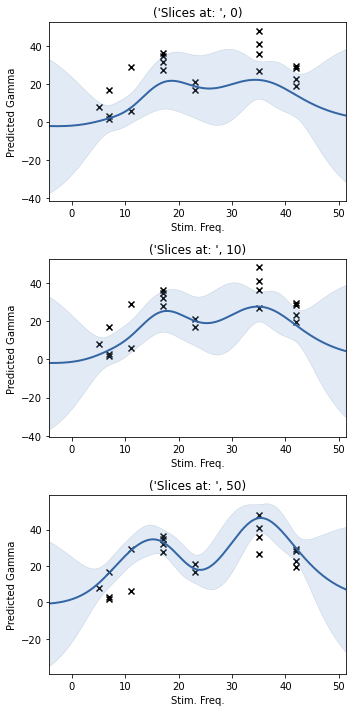

In [16]:
x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO_AF, slice_dim, ylabel)

#### 1.3.2: Use the acquisition function to guide the next freq to optimize at

In [17]:
rand_freq_1d = np.random.choice(np.arange(1,43,1), size=(n_samples))
rand_freq_1d_sorted = np.sort(rand_freq_1d)
print(rand_freq_1d_sorted)
rand_amp_1d = np.random.choice(np.arange(1,51,1), size=(n_samples))
rand_amp_1d_sorted = np.sort(rand_amp_1d)
print(rand_amp_1d_sorted, np.shape(rand_amp_1d_sorted))

[ 1  1  1  1  2  2  3  3  3  3  3  4  4  4  5  5  5  5  6  6  6  7  7  7
  7  8  8  8  9  9 10 10 10 10 10 11 11 11 11 11 12 12 13 13 13 13 13 13
 13 14 14 14 14 14 15 15 16 16 16 16 16 16 17 17 17 17 18 18 18 18 19 19
 20 20 21 21 21 21 21 21 21 22 22 22 22 23 24 24 24 24 25 25 26 26 26 27
 27 28 29 29 29 29 30 30 30 31 31 31 31 31 32 32 32 32 33 33 33 33 33 34
 34 35 35 35 36 37 37 37 37 37 38 38 38 38 38 38 39 39 39 39 40 40 41 41
 41 41 41 42 42 42]
[ 1  1  2  2  3  3  4  4  4  4  6  6  6  7  7  7  7  7  7  8  9  9  9 10
 11 11 11 11 12 12 12 12 13 13 14 14 14 14 15 15 16 16 16 16 16 17 17 17
 17 18 18 18 18 19 19 19 19 20 20 20 20 21 21 21 21 22 22 22 23 23 23 23
 24 24 25 25 25 26 26 26 26 27 28 29 29 29 30 31 31 31 31 32 32 33 33 33
 34 34 34 35 35 36 36 36 36 36 37 37 37 37 37 38 38 39 39 39 40 40 40 41
 41 41 41 42 42 42 42 43 44 44 44 44 45 45 45 46 46 46 46 47 47 48 48 49
 49 49 50 50 50 50] (150,)


In [18]:
# sample mean preStimGamma: for the Static BaO we just use the mean preStim Gamma
mean_preStimGamma = np.empty((n_samples,))
mean_preStimGamma[:] = np.mean(X0_psd, axis=0)
print(mean_preStimGamma[0], np.shape(mean_preStimGamma))

2.171337907722562 (150,)


In [19]:
print(np.shape(rand_freq_1d_sorted), np.shape(rand_amp_1d_sorted))

testX_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted, mean_preStimGamma])
print(np.shape(testX_BaO))
testX = np.transpose(testX_BaO)
print(np.shape(testX))

(150,) (150,)
(3, 150)
(150, 3)


In [20]:
# a loop to optimize at every acquistion for 50 iteration and re-optimization, then plot before and after.
ucb = np.empty((1, n_samples))
ucb_sample = np.empty((n_acquisition, 3))
postStimGamma_predicted_from_firstModel = np.empty((n_acquisition, 1))
print(np.shape(ucb))

nu = 0.1
print("nu set at: ", nu)

for a in range(1, n_acquisition):
    simY_BaO_AF = np.empty((1, n_samples))
    simMse_BaO_AF = np.empty((1, n_samples))
    simY_BaO_AF, simMse_BaO_AF= trained_model_BaO_AF.predict(testX);
    
    ucb= model.acquisition_function(simY_BaO_AF, simMse_BaO_AF, nu, 1)
    max_ucb = np.max(ucb, axis=0)
    argMax_ucb = ucb.argmax()

    # find the values of argMax_ucb in the sample grid
    ucb_sample[a,:] = testX[argMax_ucb]
    ucb_sample_reshaped = np.reshape(ucb_sample[a,:], (1,3))
    
    # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
    postStimGamma_predicted_from_firstModel[a] = trained_model_BaO.posterior_samples(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
    simY_BaO, simMse_BaO =  trained_model_BaO.predict(ucb_sample_reshaped);
    
    # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
    next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample[a,0])], 'Stim_2':[int(ucb_sample[a,1])]})
    U1_init = pd.concat([U1_init, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)

    # sum_preStim_gamma
    next_preStimGamma = pd.DataFrame({'sum_preStim_gamma':[mean_preStimGamma[0]]})
    X0_psd_init = pd.concat([X0_psd_init, next_preStimGamma], ignore_index=True, axis=0)
    
    # Concatenate the first model predicted postStimGamma 
    next_postStimGamma = np.empty((1,1))
    next_postStimGamma[0,:] = [postStimGamma_predicted_from_firstModel[a]]
    X1_init = np.append(X1_init, next_postStimGamma, axis=0)
    
    # trained_model_BaO_AF.add_observer()
    # trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000)
    trained_model_BaO_AF = model.bayes_opt_update_state(U1_init, X1_init, ker_BaO_AF)
    
    

(1, 150)
nu set at:  0.1
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s10  0006   7.388558e+01   1.034604e-04 
    00s18  0011   7.386745e+01   1.848341e-04 
    00s41  0026   7.386300e+01   9.729423e-11 
Runtime:     00s41
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s15  0007   7.646827e+01   5.875772e-07 
    00s26  0013   7.646807e+01   6.702360e-11 
Runtime:     00s26
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0003   7.921499e+01   1.699337e-05 
    00s19  0009   7.921188e+01   2.990175e-04 
    00s27  0014   7.921116e+01   1.893520e-09 
Runtime:     00s27
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s09  0003   8.138193e+01   1.813682e-04 
    00s19  0007   8.138161e+01 

#### 1.3.3: Plot before and after optimization 

Text(0, 0.5, 'postStim Gamma')

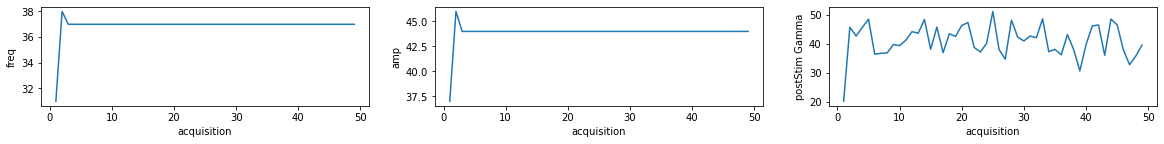

In [21]:
fig = plt.figure(figsize=(20,4));
plt.subplot(2,3,1)
plt.plot(np.arange(1,50), ucb_sample[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")

plt.subplot(2,3,2)
plt.plot(np.arange(1,50), ucb_sample[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")

plt.subplot(2,3,3)
plt.plot(np.arange(1,50), postStimGamma_predicted_from_firstModel[1:,], label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")

# plot the model's max (freq, amp, postStim gamma) at each iteration

In [22]:
print(ucb_sample)
print(ucb_sample[1:,0])
print(ucb_sample[1:,1])


[[1.33669511e-046 1.32452083e+094 2.47361268e-100]
 [3.10000000e+001 3.70000000e+001 2.17133791e+000]
 [3.80000000e+001 4.60000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+001 2.17133791e+000]
 [3.70000000e+001 4.40000000e+0

In [23]:
print(postStimGamma_predicted_from_firstModel[1:])

[[20.26272352]
 [45.82060813]
 [42.78814922]
 [45.74611806]
 [48.60300337]
 [36.52579429]
 [36.82039384]
 [36.95362382]
 [39.85023467]
 [39.48335307]
 [41.30178932]
 [44.30168749]
 [43.75839232]
 [48.47688717]
 [38.23295081]
 [45.87427267]
 [37.04424276]
 [43.57266406]
 [42.66281992]
 [46.4335132 ]
 [47.43257421]
 [38.84812488]
 [37.27464779]
 [40.24467478]
 [51.26613292]
 [38.13037967]
 [34.8015918 ]
 [48.28716712]
 [42.4021268 ]
 [41.08840139]
 [42.79024026]
 [42.19227392]
 [48.71914919]
 [37.38884606]
 [38.18518894]
 [36.30905938]
 [43.28471727]
 [38.14839691]
 [30.75776016]
 [39.86292614]
 [46.25894028]
 [46.60131254]
 [36.15152738]
 [48.66142397]
 [46.61495515]
 [38.04728934]
 [32.89044743]
 [35.91137537]
 [39.67342607]]


### 1.4: Dynamic BaO

In [24]:
dynamic_model = state_dr_gp()

#### 1.4.1: Instead of mean preStimGamma we will use sorted preStimGamma vector that goes from min to max from trial 0-75 and then to min from 75-150. 

In [25]:
# sample min to max preStimGamma: for the Dynamic BaO 
# input_data
U1_X0 = U1.join(X0_psd)

In [26]:
U1_init_dynamic = U1.loc[0:n_burn_in-1,:]
X1_init_dynamic = X1[0:n_burn_in,:]

print('freq and amplitude used are: \n', U1_init_dynamic, np.shape(U1_init_dynamic))
print('sum postStim gamma are: \n', X1_init_dynamic, np.shape(X1_init_dynamic))

freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]
 [28.54172459]
 [48.27246273]
 [ 6.00115734]
 [ 2.96172226]
 [27.66113194]
 [29.12656713]
 [34.90446486]
 [40.92827493]
 [ 8.02083908]
 [22.91482488]
 [21.03253269]
 [16.68539907]
 [26.89885834]
 [31.85413914]
 [ 1.7873916 ]
 [19.26713018]] (20, 1)


In [27]:
ker_BaO_dynamic = GPy.kern.Matern52(input_dim=2, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [28]:
hill_sum_preStim_gamma = np.empty((n_samples))
min_sum_preStim_gamma = np.min(U1_X0['sum_preStim_gamma'])
max_sum_preStim_gamma = np.max(U1_X0['sum_preStim_gamma'])
half_n_samples = int(n_samples/2)
step_size = (max_sum_preStim_gamma-min_sum_preStim_gamma)/half_n_samples
hill_sum_preStim_gamma[0:half_n_samples] = np.arange(min_sum_preStim_gamma, max_sum_preStim_gamma, step_size)
hill_sum_preStim_gamma[half_n_samples:150] = np.arange(max_sum_preStim_gamma,min_sum_preStim_gamma, -step_size)
print(hill_sum_preStim_gamma[0:3], np.shape(hill_sum_preStim_gamma))


[0.81379952 0.94960391 1.0854083 ] (150,)


In [29]:
# append U1_init with hill_sum_preStim_gamma_init
hill_sum_preStim_gamma_pd = pd.DataFrame({'sum_preStim_gamma':hill_sum_preStim_gamma})
hill_sum_preStim_gamma_pd.head()


,sum_preStim_gamma
0,0.813800
1,0.949604
2,1.085408
3,1.221213
4,1.357017


In [30]:
X0_init_dynamic = hill_sum_preStim_gamma_pd.loc[0:n_burn_in-1]
print(X0_init_dynamic, np.shape(X0_init_dynamic)) #.loc[0:10,:]

    sum_preStim_gamma
0            0.813800
1            0.949604
2            1.085408
3            1.221213
4            1.357017
5            1.492821
6            1.628626
7            1.764430
8            1.900235
9            2.036039
10           2.171843
11           2.307648
12           2.443452
13           2.579257
14           2.715061
15           2.850865
16           2.986670
17           3.122474
18           3.258279
19           3.394083 (20, 1)


In [31]:
# U1_X0_init = np.transpose(U1_X0_init)
print(np.shape(U1_X0_init))

(20, 3)


Text(0, 0.5, 'sum_preStim_gamma')

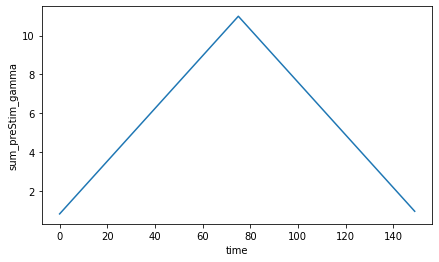

In [32]:
fig = plt.figure(figsize=(7,4));
plt.plot(np.arange(0,n_samples), hill_sum_preStim_gamma, label=r"sum_preStim_gamma");
plt.xlabel("time")
plt.ylabel("sum_preStim_gamma")

In [33]:
testX_Dynamic_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted, hill_sum_preStim_gamma])
print(np.shape(testX_Dynamic_BaO))
testX_Dynamic = np.transpose(testX_Dynamic_BaO)
print(np.shape(testX_Dynamic_BaO))

(3, 150)
(3, 150)


In [34]:
print(np.shape(U1_X0_init))
print(np.shape(X1_init_dynamic))

(20, 3)
(20, 1)


#### 1.4.2: Initial training of the Dynamic model

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x26a16a74ee0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x26a16e149d0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0001   1.208672e+03   9.179617e+04 
    00s15  0007   2.155162e+02   9.304256e+01 
    00s17  0008   1.702266e+02   4.102541e+01 
    00s80  0053   6.946105e+01   2.090506e-10 
Runtime:     00s80
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x26a145318b0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x26a16d2da60>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x26a16e1bd30>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x26a1457b2b0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x26a1457b2e0>]}

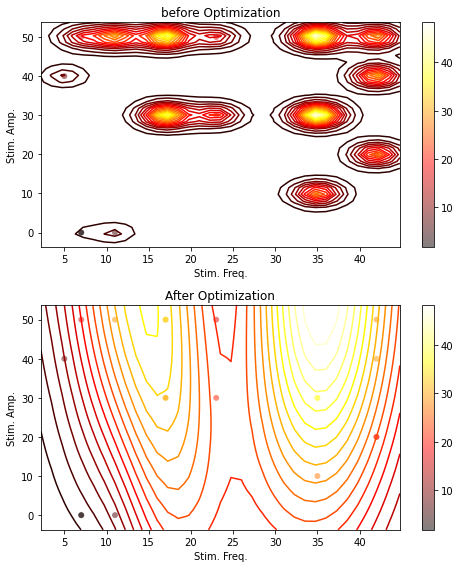

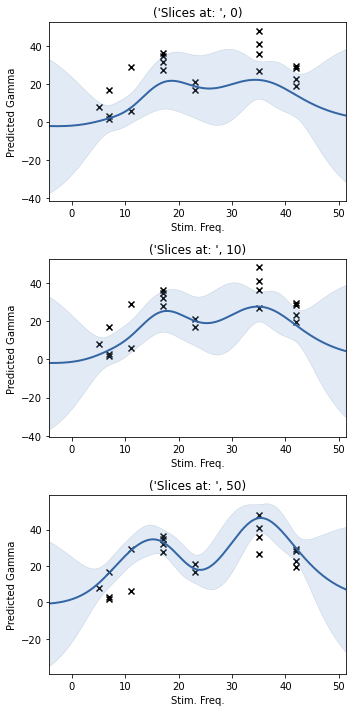

In [35]:
# Initialize a dynamic model:
x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_init_dynamic, X1_init_dynamic, 
                                                                                               ker_BaO_dynamic, slice_dim, ylabel)

# trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_X0_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
# trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);

# figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
# canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
#                         title='After Optimization');
# display(canvas)
# ax = plt.gca()
# PCM = ax.get_children()[0]
# plt.colorbar(PCM, ax=ax)

# # Plotting slices of the model at amplitudes of 0, 10, and 50
# slices = [0, 10, 50]
# figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

# for i, y in zip(range(3), slices):
#     print((1,y));

# canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
#                     xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

# display(canvas);

In [36]:
simY_BaO_dynamic, simMse_BaO_dynamic= trained_model_BaO_Dynamic.predict(testX_Dynamic_BaO);
print(simY_BaO_dynamic, simMse_BaO_dynamic)
ucb_dynamic= dynamic_model.acquisition_function(simY_BaO_dynamic, simMse_BaO_dynamic, nu, 1)
print(np.shape(ucb_dynamic))
max_ucb_dynamic = np.max(ucb_dynamic, axis=0)
print(max_ucb_dynamic)
argMax_ucb_dynamic = ucb_dynamic.argmax()
print(argMax_ucb_dynamic)

[[-1.52078843]
 [-1.52078843]
 [-1.58419181]] [[130.0430273 ]
 [130.0430273 ]
 [136.91133424]]
(3, 1)
[41.61129302]
2


#### 1.4.3: Using the acquisition function to guide the training of the Dynamic model

In [37]:
ucb_dynamic = np.empty((1, n_samples))
ucb_sample_dynamic = np.empty((n_acquisition, 3))
postStimGamma_predicted_from_firstModel_dynamic = np.empty((n_acquisition, 1))
print(np.shape(ucb_dynamic))

nu = 0.1
print("nu set at: ", nu)

for a in range(1, n_acquisition):
    simY_BaO_dynamic = np.empty((1, n_samples))
    simMse_BaO_dynamic = np.empty((1, n_samples))
    
    simY_BaO_dynamic, simMse_BaO_dynamic= trained_model_BaO_Dynamic.predict(testX_Dynamic_BaO);
    
    ucb_dynamic= dynamic_model.acquisition_function(simY_BaO_dynamic, simMse_BaO_dynamic, nu, 1)
    max_ucb_dynamic = np.max(ucb_dynamic, axis=0)
    print(max_ucb_dynamic)
    argMax_ucb_dynamic = ucb_dynamic.argmax()
    print(argMax_ucb_dynamic)
    # find the values of argMax_ucb in the sample grid
    ucb_sample_dynamic[a, :] = testX_Dynamic_BaO[:, argMax_ucb_dynamic]
    print(ucb_sample_dynamic[a,:])
    ucb_sample_reshaped = np.reshape(ucb_sample_dynamic[a,:], (1,3))
    
    # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
    postStimGamma_predicted_from_firstModel_dynamic[a] = trained_model_BaO_Dynamic.posterior_samples(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
    simY_BaO_dynamic, simMse_BaO_dynamic =  trained_model_BaO_Dynamic.predict(ucb_sample_reshaped);
    
    # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
    next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample_dynamic[a,0])], 'Stim_2':[int(ucb_sample_dynamic[a,1])]})
    U1_init = pd.concat([U1_init, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)

    # sum_preStim_gamma
    next_preStimGamma = pd.DataFrame({'sum_preStim_gamma':[hill_sum_preStim_gamma[a]]})
    X0_psd_init = pd.concat([X0_psd_init, next_preStimGamma], ignore_index=True, axis=0)
    
    # Concatenate the first model predicted postStimGamma 
    next_postStimGamma = np.empty((1,1))
    next_postStimGamma[0,:] = [postStimGamma_predicted_from_firstModel_dynamic[a]]
    X1_init = np.append(X1_init, next_postStimGamma, axis=0)
    
    # trained_model_BaO_AF.add_observer()
    # trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000)
    trained_model_BaO_Dynamic = dynamic_model.bayes_opt_update_state(U1_init, X1_init, ker_BaO_dynamic)
    
    

(1, 150)
nu set at:  0.1
[41.61129302]
2
[1.        2.        1.0854083]
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s15  0007   2.238264e+02   5.365541e-02 
    00s19  0009   2.236620e+02   2.945379e-04 
    00s52  0036   2.235561e+02   1.709692e-12 
Runtime:     00s52
Optimization status: Converged

[15.23709252]
2
[1.        2.        1.0854083]
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s17  0009   2.265902e+02   2.804584e-08 
    00s18  0010   2.265902e+02   2.804584e-08 
Runtime:     00s18
Optimization status: Converged

[14.58154335]
2
[1.        2.        1.0854083]
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s16  0007   2.292450e+02   1.107205e-08 
    00s28  0013   2.292450e+02   4.339131e-09 
Runtime:     00s28
Optimization status: Converged

[13.03161326]
2
[1.        2.        1.0854083]
Running L-BFGS-B (Scipy i

In [38]:
testX_Dynamic_BaO[:,argMax_ucb_dynamic]

array([1.       , 2.       , 1.0854083])

Text(0, 0.5, 'postStim Gamma')

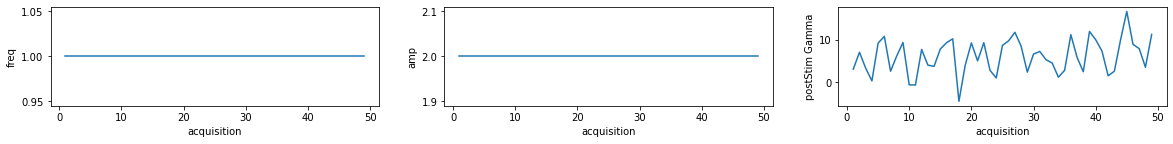

In [39]:
fig = plt.figure(figsize=(20,4));
plt.subplot(2,3,1)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")

plt.subplot(2,3,2)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")

plt.subplot(2,3,3)
plt.plot(np.arange(1,50), postStimGamma_predicted_from_firstModel_dynamic[1:,], label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")

x_BaO, y_BaO, trained_model_BaO = model.bayes_opt_update_state(trained_model_BaO, U1, X0_psd, X1, n_samples, n_burn_in, sample, acquisition_function, 
                                                               ker_BaO, slice_dim, ylabel, initialize_data_dr_sim)

# initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)

### Acquisition Function pseudo code and draft
function [X_samples, Y_samples, X_optimal_est, Y_optimal_est, Y_ground_truth] =  ...
    bayes_opt_on_state_dr_model(objective_model, input_space, n_samples, n_burn_in, acquisition_function, acq_params, measurement_function)


X_samples       = nan(n_samples, size(input_space,2));
X_optimal_est   = nan(n_samples, size(input_space,2));

Y_samples       = nan(n_samples, 1);
Y_optimal_est   = nan(n_samples, 1);
Y_ground_truth  = nan(n_samples, 1);

objective_est   = gp_object(); % GP model used in BaO 
burn_in_idx     = randi(size(input_space,1), n_burn_in,1);

objective_model.set_initial_state(); % Ground Truth simulation model 

for c1 = 1:n_samples
    
    if c1 <= n_burn_in
        X_samples(c1,:)     = input_space(burn_in_idx(c1),:);
    else
        X_samples(c1,:)     = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, c1);
    end
    
    Y_samples(c1,1)         = objective_model.sample(X_samples(c1,:));
    
    if c1 > 1    
        objective_est.initialize_data(X_samples(1:c1,:), Y_samples(1:c1)) % Exclude NaN when initializing GP

        [X_optimal_est(c1,:), Y_optimal_est(c1,:)] ...
            = objective_est.discrete_extrema(input_space);

        Y_ground_truth(c1)  = objective_model.predict_state(X_optimal_est(c1,:));
    end
    objective_model.transition_state();
end

end


#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end